In [9]:

import pandas as pd
import numpy as np
import os

# Assuming that the csv file is loaded into a pandas DataFrame named df

df = pd.read_csv('C:\\Users\\zzzl0\\Desktop\\predicting-and-avoiding-dog-barking-behaviour\\predicting-and-avoiding-dog-barking-behaviour\\output\\model2_audio_clips\\summary.csv')

# Extracting unique dog names from 'File_Name'
df['Dog_Name'] = df['File_Name'].apply(lambda x: x.split('_')[0])
unique_dogs = df['Dog_Name'].unique()

# Create output directory if it doesn't exist
output_dir = 'C:\\Users\\zzzl0\\Desktop\\predicting-and-avoiding-dog-barking-behaviour\\predicting-and-avoiding-dog-barking-behaviour\\output\\model2_audio_clips\\augment'
os.makedirs(output_dir, exist_ok=True)

for dog in unique_dogs:
    # Filtering rows corresponding to the current dog
    df_dog = df[df['Dog_Name'] == dog]

    # Initializing new DataFrame for storing augmented data
    df_aug = pd.DataFrame(columns=['sound_class_list', 'output', 'File_Name'])

    for idx, row in df_dog.iterrows():
        sound_class_list = row[:-2].tolist()  # Converting row into list and excluding the 'File_Name' and 'Dog_Name'
        sound_class_list = [x for x in sound_class_list if not np.isnan(x)]  # Removing NaNs
        
        # Generating all continuous subsets and their corresponding class
        for i in range(len(sound_class_list) - 1):  # Excluding the last sound in each row
            for j in range(i+1, len(sound_class_list)):
                fragment = sound_class_list[i:j]
                if j == len(sound_class_list) - 1:  # Marking interval as 'Y' if fragment contains the second-last sound
                    output = 'Y'
                else:
                    output = 'N'  # Otherwise, marking it as 'N'
                    
                # Appending new row to df_aug
                new_row = pd.DataFrame([{'sound_class_list': fragment, 'output': output, 'File_Name': row['File_Name']}])
                df_aug = pd.concat([df_aug, new_row], ignore_index=True)

    # Saving the augmented dataframe to a new CSV file
    df_aug.to_csv(os.path.join(output_dir, f'{dog}_augmented_data.csv'), index=False)


NameError: name 'data' is not defined

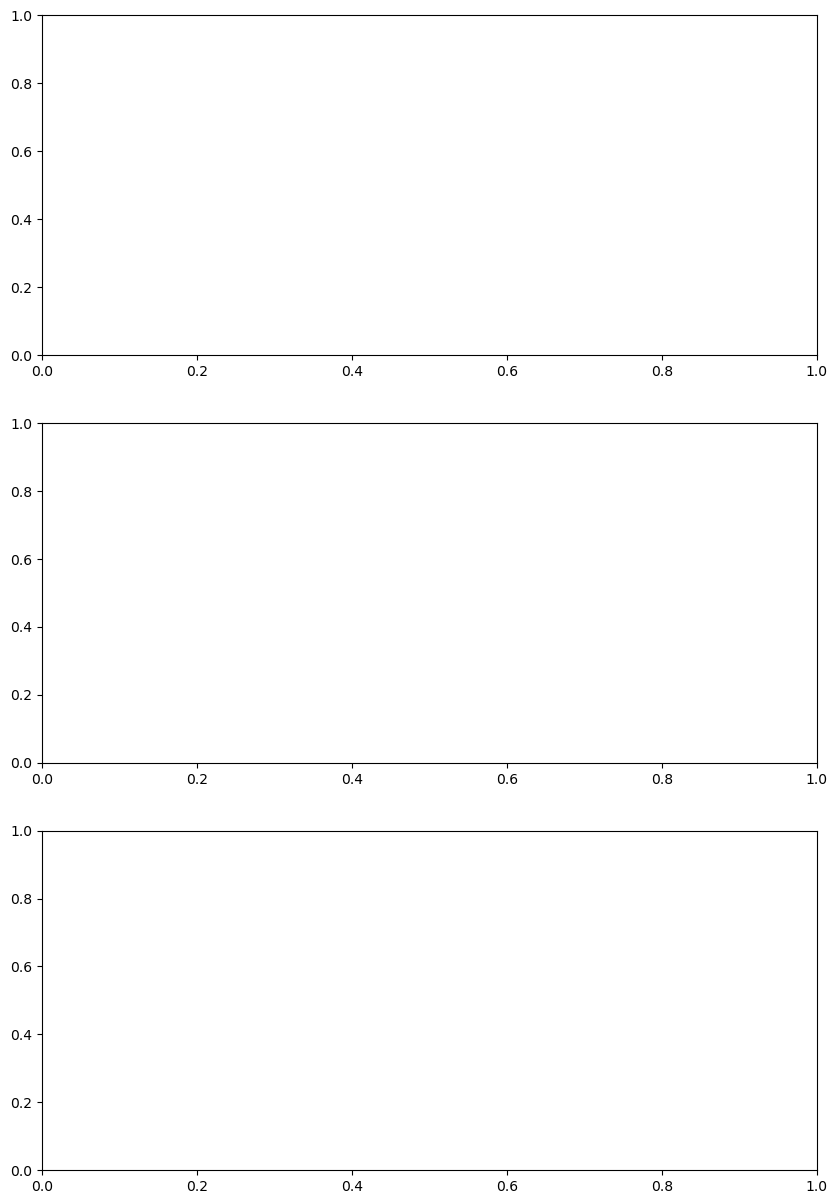

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import os
import glob
import ast

# Define a function to preprocess and train a model on given data
def train_model(df):
    print('training..')
    # Convert the string representation of lists into actual lists
    df['sound_class_list'] = df['sound_class_list'].apply(ast.literal_eval)

    # Creating separate columns for each sound
    df_sound = pd.DataFrame(df['sound_class_list'].to_list(), columns=[f'Sound_{i+1}' for i in range(df['sound_class_list'].str.len().max())])
    
    # Joining the sounds dataframe with the original dataframe
    df = pd.concat([df_sound, df['output']], axis=1)
    
    # Converting 'output' into binary
    df['output'] = df['output'].map({'Y': 1, 'N': 0})
    
    # Defining X and y
    X = df.drop(columns=['output'])
    y = df['output']
    
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Filling NaNs with zeros
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    
    # Creating the Logistic Regression model
    model = LogisticRegression()
    
    # Training the model
    model.fit(X_train, y_train)
    
    # Making predictions on the test set
    y_pred = model.predict(X_test)
    
    # Return the accuracy of the model
    print(accuracy_score(y_test, y_pred))
    return accuracy_score(y_test, y_pred)

# List all augmented data files
augmented_files = glob.glob('C:\\Users\\zzzl0\\Desktop\\predicting-and-avoiding-dog-barking-behaviour\\predicting-and-avoiding-dog-barking-behaviour\\output\\model2_audio_clips\\augment\\*_augmented_data.csv')

# Initialize list to store accuracy scores
accuracy_scores = []

# For each file, load the data, train the model, and add the accuracy to the list
for file in augmented_files:
    df = pd.read_csv(file)
    accuracy = train_model(df)
    accuracy_scores.append(accuracy)

# Calculate and print the average accuracy
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print('Average Accuracy:', average_accuracy)
